In [5]:
import numpy
# scipy.special для отображения функции сигмоиды expit()
import scipy.special
# библиотека для графического отображения массивов
import matplotlib.pyplot as plt
# размещение графики в данном блокноте, а не в отдельном окне
%matplotlib inline
# библиотека для работы с файлами .csv
import csv

In [6]:
# определение класса нейронной сети
class neuralNetwork:

    # инициализация нейронной сети
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # установка количества узлов в каждом входном, скрытом, выходном слое
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # матрицы весов связей, wih и who
        # веса внутри массивов — w_i_j, где связь идет от узла i к узлу j в следующем слое
        # w11 w21
        # w12 w22 и т. д.
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # скорость обучения
        self.lr = learningrate

        # функция активации — сигмоидальная функция
        self.activation_function = lambda x: scipy.special.expit(x)

        pass


    # обучение нейронной сети
    def train(self, inputs_list, targets_list):
        # преобразование списка входов в двумерный массив
        inputs = numpy.array(inputs_list, ndmin=2).T
        target = numpy.array(targets_list, ndmin=2).T

        # вычисление сигналов в скрытом слое
        hidden_inputs = numpy.dot(self.wih, inputs)
        # вычисление сигналов, выходящих из скрытого слоя
        hidden_outputs = self.activation_function(hidden_inputs)

        # вычисление сигналов в конечном выходном слое
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # вычисление сигналов, выходящих из конечного выходного слоя
        final_outputs = self.activation_function(final_inputs)

        # ошибка выходного слоя — это (target - actual)
        output_errors = target - final_outputs

        # ошибка скрытого слоя — это output_errors, разделенные по весам, рекомбинированные в скрытых узлах
        hidden_errors = numpy.dot(self.who.T, output_errors)

        # обновить веса для связей между скрытыми и выходными слоями
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))

        # обновить веса для связей между входными и скрытыми слоями
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))

        pass


    # запрос к нейронной сети
    def query(self, inputs_list):
        # преобразовать список входов в двумерный массив
        inputs = numpy.array(inputs_list, ndmin=2).T
        # вычислить сигналы в скрытом слое
        hidden_inputs = numpy.dot(self.wih, inputs)
        # вычислить сигналы, выходящие из скрытого слоя
        hidden_outputs = self.activation_function(hidden_inputs)
        # вычислить сигналы в конечном выходном слое
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # вычислить сигналы, выходящие из конечного выходного слоя
        final_outputs = self.activation_function(final_inputs)

        return final_outputs

In [7]:
# Число входных, скрытых и выходных узлов
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# learning rate
learning_rate = 0.1

# Создаем сущность нейронной сети
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

In [8]:
# загружаем CSV-файл данных обучения mnist в список
training_file_path = "sample_data/train_60_357.csv";

training_data_file = open(training_file_path, 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

# загружаем CSV-файл данных тестирования mnist в список
test_file_path = "sample_data/test_30_357.csv";
test_data_file = open(test_file_path, 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [9]:
predicted_list = []

# Функция тестирования нейронной сети и формирования массива с угаданными значениями
def get_mse(data_list, is_gen_predicted_list=False):

  # Массив нулей и единиц, из которого далее формируется mse
  scorecard = []

  # Проходимся по всем значения датасета
  for record in data_list:
      # разделить запись запятыми ','
      all_values = record.split(',')
      # правильный ответ — первое значение
      correct_label = int(all_values[0])
      # масштабируем и сдвигаем входы
      inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
      # запросить сеть
      outputs = n.query(inputs)
      # индекс наибольшего значения соответствует метке
      label = numpy.argmax(outputs)
      # добавить 0 или 1 в зависимости от того, правильно или неправильно угадано число
      if (label == correct_label):
          scorecard.append(1)
      else:
          scorecard.append(0)
          pass

      pass

      if (is_gen_predicted_list): predicted_list.append(label)


  scorecard_array = numpy.asarray(scorecard)
  performance = scorecard_array.sum() / scorecard_array.size
  mse = 1 - performance
  return mse

In [10]:
# цикл обучения нейронной сети

# число эпох
epochs = 50
# Массив с процентной точностью распознавания чисел за каждую эпоху
test_mse_list = []

for e in range(epochs):
    # Проходим по всем обучающим примерам
    for record in training_data_list:
        # разделить запись запятыми ','
        all_values = record.split(',')
        # масштабировать и сдвинуть входы
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # создать целевые выходные значения (все 0.01, кроме желаемой метки, которая равна 0.99)
        targets = numpy.zeros(output_nodes) + 0.01
        # all_values[0] — целевая метка для этой записи
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        pass
    pass

    test_mse_list.append(get_mse(test_data_list))

In [11]:
# Определение процента правильно распознаваемых образцов в обучающей и в тестовой выборках
training_performance_percent = 100 * (1 - get_mse(training_data_list))
test_performance_percent = 100 * (1 - test_mse_list[len(test_mse_list) - 1])
print("Процент правильно распознаваемых образцов в обучающей выборке:", training_performance_percent, "%")
print("Процент правильно распознаваемых образцов в тестовой выборке:", test_performance_percent, "%")

Процент правильно распознаваемых образцов в обучающей выборке: 100.0 %
Процент правильно распознаваемых образцов в тестовой выборке: 96.66666666666667 %


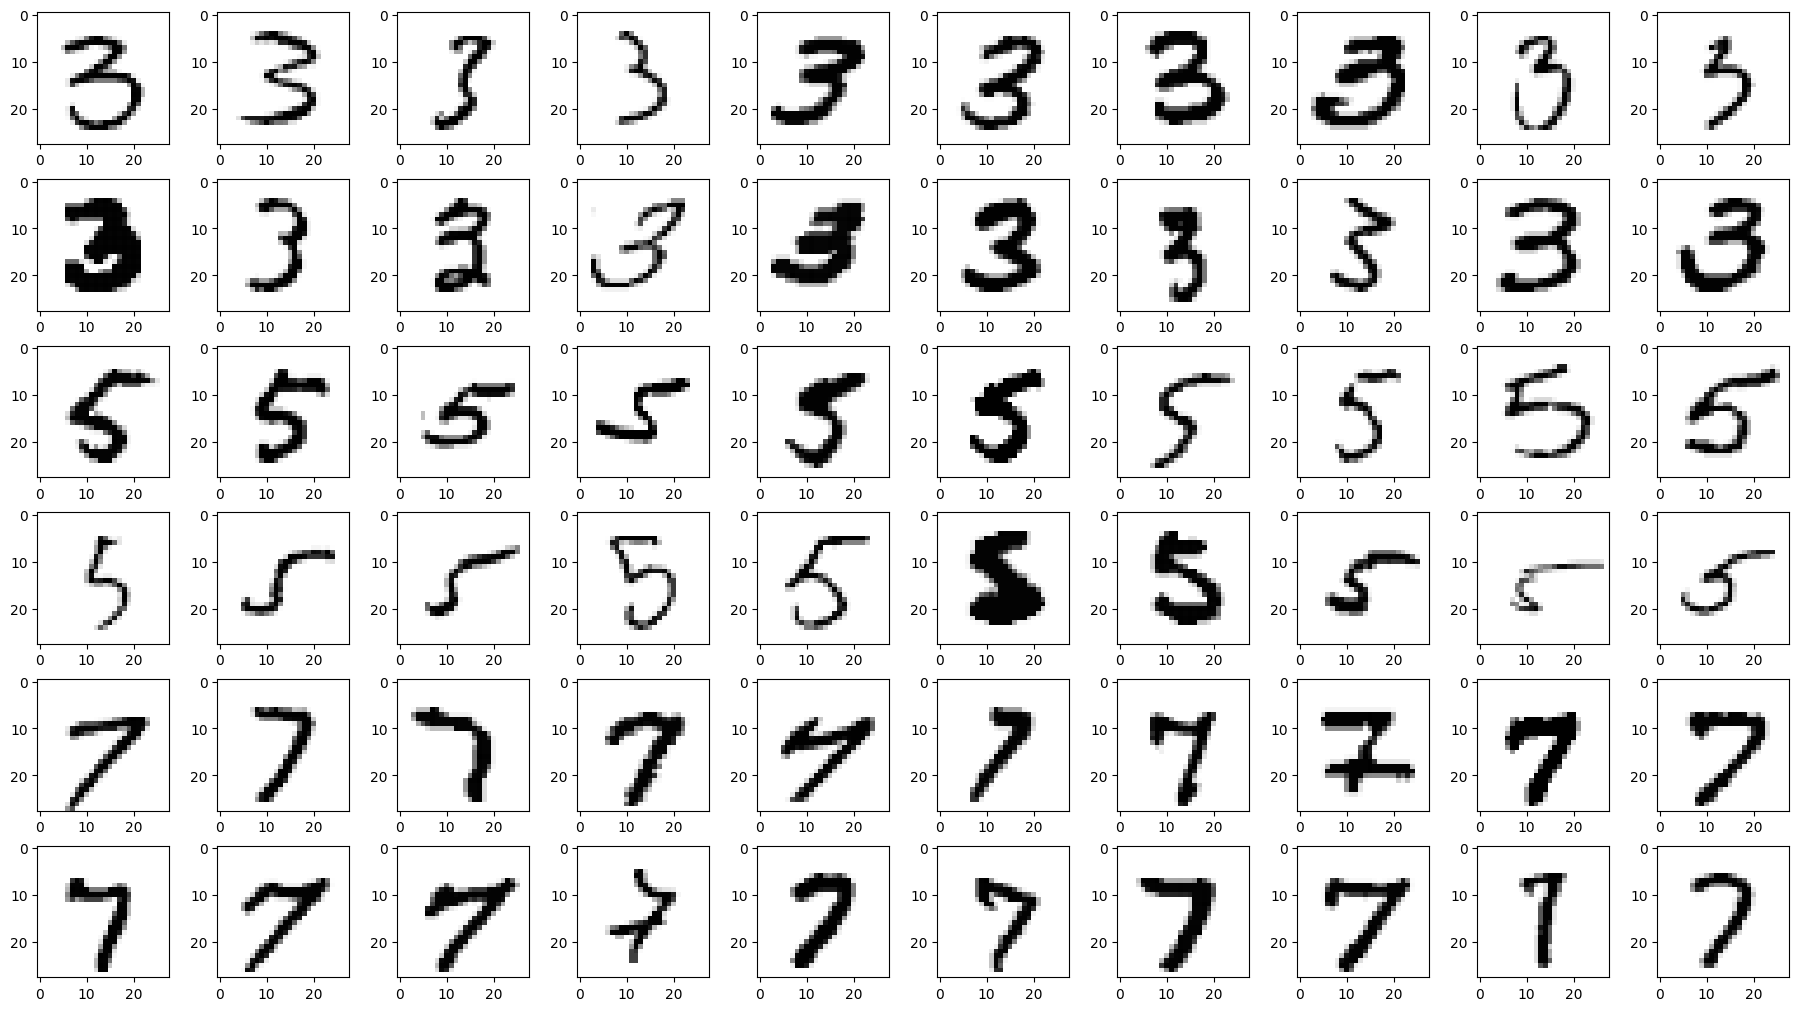

In [12]:
# Функция отображения набора
def show_mnist_data(file_path, is_predict=False):
   # чтение массива обучающих данных (60 или 30 примеров)
   file_data = []
   with open(file_path, 'r') as csv_file:
      csvreader = csv.reader(csv_file)
      for row in csvreader:
         file_data.append(row)       # формирование массива 748 х 60
   # расположение рисунков 6 или 3 строки по 10 цифр
   col_num = 10
   rows_num = int(len(file_data) / col_num)
   fig, axs = plt.subplots(rows_num, col_num, figsize=(18,10), constrained_layout=True)
   num = 0
   for i in range(rows_num):
      for j in range(col_num):
         # преобразование массива из 784 чисел к формату 28х28
         if is_predict == True: axs[i][j].text(0, -5, "Распознано как " + str(predicted_list[i*col_num+j]), fontsize=10)
         image_array=numpy.asfarray(file_data[num][1:],dtype='int64').reshape((28,28))
         axs[i][j].imshow(image_array, cmap='Greys', interpolation='None')
         num += 1

# Показать обучающий набор
show_mnist_data(training_file_path)

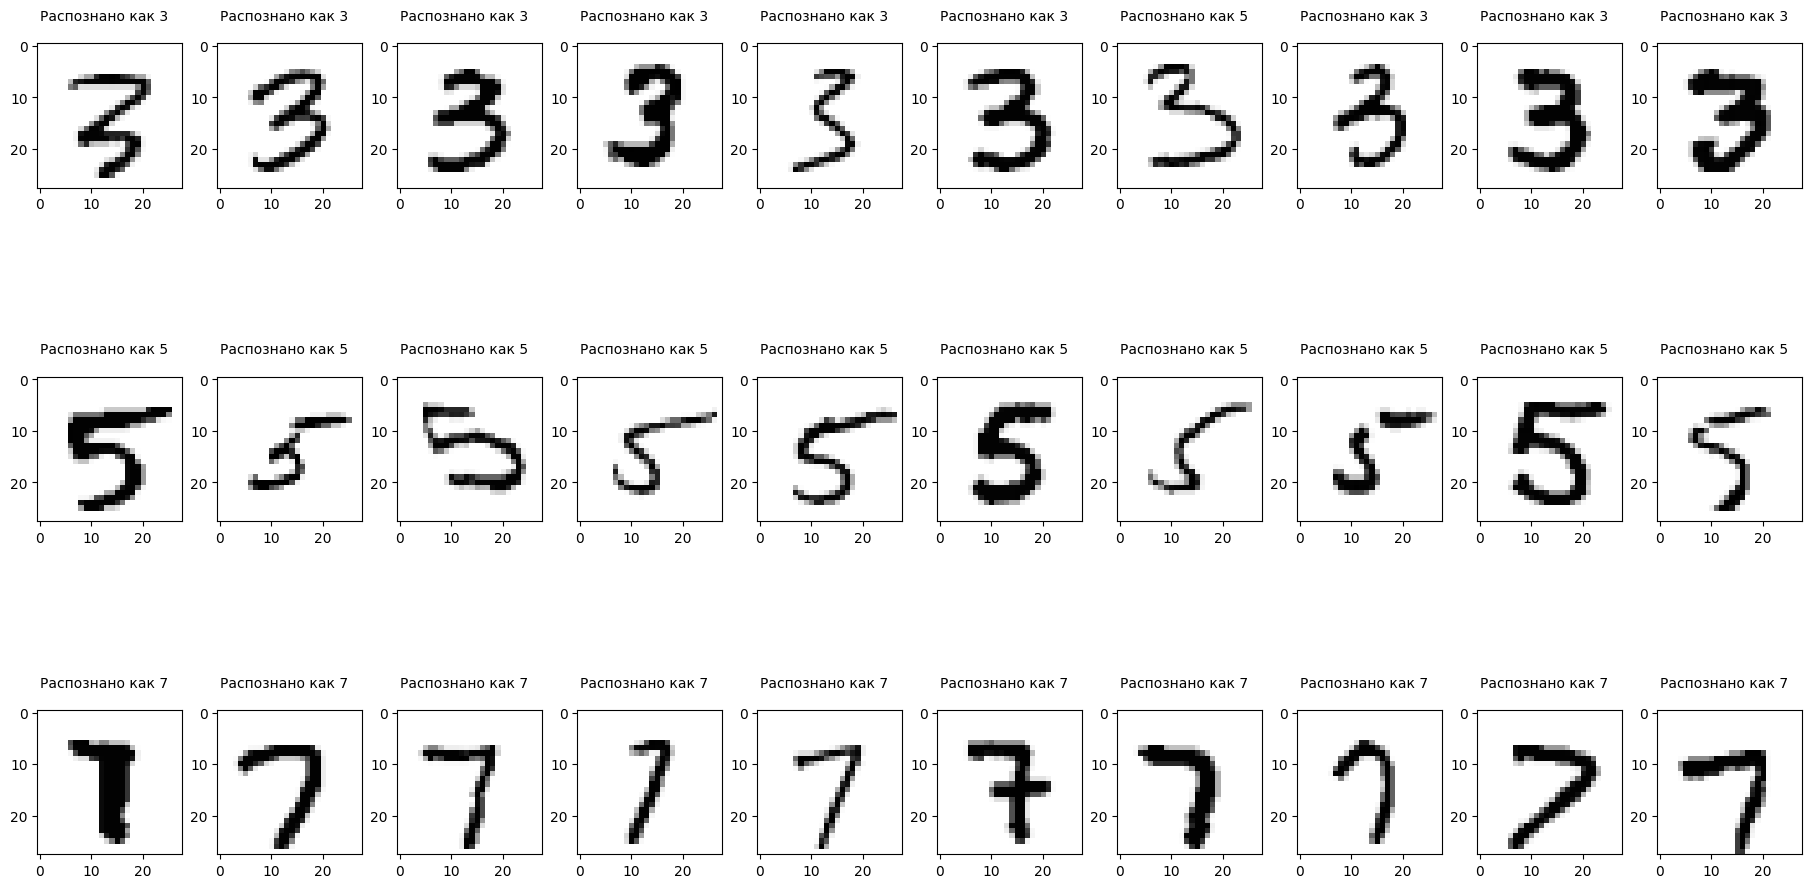

In [13]:
# Показать тестовый набор
get_mse(test_data_list, is_gen_predicted_list=True)
show_mnist_data(test_file_path, is_predict=True)

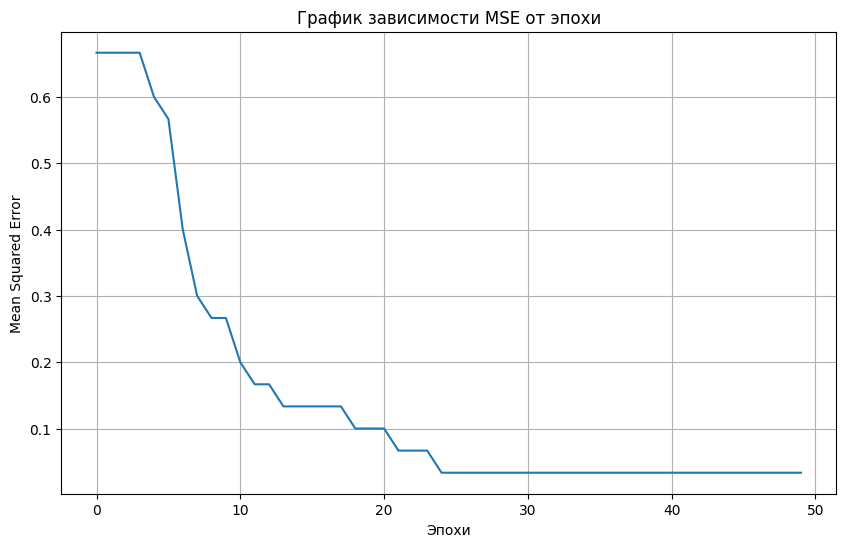

In [14]:
# Рисуем график зависимости MSE от эпохи
plt.figure(figsize=(10, 6))
plt.plot(range(len(test_mse_list)), test_mse_list)
plt.title("График зависимости MSE от эпохи")
plt.xlabel("Эпохи")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.show()